In [37]:
# External Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, Reshape, SimpleRNN, MaxPooling1D, Conv1D
from keras import initializers
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re 

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [49]:
# Functions 

def CountPlot(data, title):
    plot = plt.axes()
    plot.set_title(title)
    sns.countplot(data)
    plot.set_xlabel('label')
    plot.set_xticklabels(['Fake(0)','Real(1)'])
    return plot

def CorpusGen(text):
    # Removes numbers, lowercases words, removes stopwords, word tokenizes, and finally lemmantizes
    lemmatizer = WordNetLemmatizer()
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

    corpus = list()
    for i in range(0,len(text)):
        message = re.sub('[^a-zA-Z]', ' ', text.iloc[i])
        message = message.lower()
        message = word_tokenize(message)
        message = list(lemmatizer.lemmatize(w) for w in message if not w in stopwords.words('english'))
        message = ' '.join(message)
        corpus.append(message)
    return corpus

def plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

In [13]:
# Import Data
filepath = "Data\WELFake_Dataset.csv\WELFake_Dataset.csv"

raw_data = pd.read_csv(filepath)


In [14]:
# Data Cleaning
cols = [x for x in raw_data.columns if x in ['title', 'text', 'label']]
clean_data = raw_data[cols]
clean_data.dropna(axis=0, inplace=True)
print(clean_data.shape)
clean_data.head()

(71537, 3)


,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


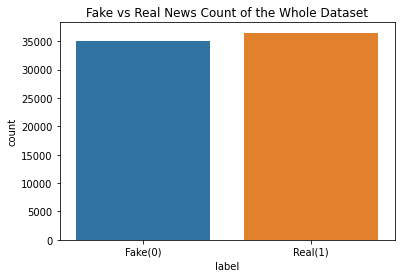

In [50]:
fulldata_countplot = CountPlot(clean_data['label'], 'Fake vs Real News Count of the Whole Dataset')

In [16]:
# I want to initially work with a smaller subset of the data
subset_data_one = clean_data.sample(frac = 0.2)
print(subset_data_one.shape)
subset_data_one.head()

(14307, 3)


,title,text,label
9277,Obama to Veto Bill Allowing 9/11 Lawsuits Agai...,WASHINGTON — The White House said on Monday...,0
54537,"COLLEGE CAMPUS BANS Chalk, Fears Students Migh...",Remember when college campuses were considered...,1
35895,What Will Happen to Your Guns Under President ...,21st Century Wire says Legacy note to Obama s ...,1
40553,HILLARY’S CHICKENS ARE COMIN’ HOME TO ROOST: N...,Hillary may have gotten away with lying to the...,1
27656,"Ex-British spy paid $168,000 for Trump dossier...",WASHINGTON (Reuters) - A Washington research f...,0


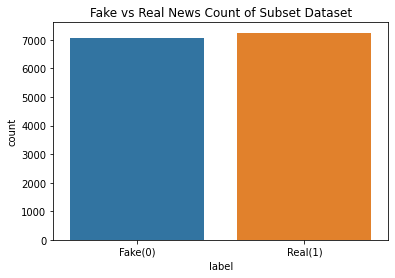

In [51]:
subsetdata_countplot = CountPlot(subset_data_one['label'], 'Fake vs Real News Count of Subset Dataset')

In [18]:
# Model 1

In [19]:
corpus_one = CorpusGen(subset_data_one['text'])

[nltk_data] Downloading package stopwords to C:\Users\Liam's
[nltk_data]     Computer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Liam's
[nltk_data]     Computer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Liam's
[nltk_data]     Computer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Liam's
[nltk_data]     Computer\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [20]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus_one)
word_index = tokenizer.word_index
vocab_size=len(word_index)
sequences = tokenizer.texts_to_sequences(corpus_one)

Percentage of Articles with length less than 600 words:  89.23603830292863


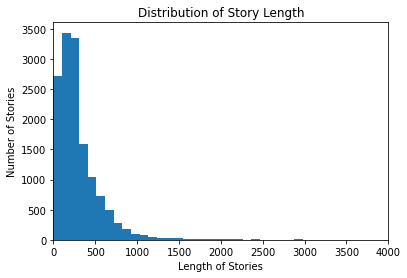

In [21]:
list = []
count = 0
for i in range(14307):
    length = len(sequences[i])
    list.append(length)
    if length <= 600:
        count += 1

plt.hist(list, bins=100)
plt.xlim(0,4000)
plt.xlabel('Length of Stories')
plt.ylabel('Number of Stories')
plt.title('Distribution of Story Length')
percent = count / len(sequences)
print('Percentage of Articles with length less than 600 words:  ' + str((count / len(sequences) * 100)))

In [22]:
padded = pad_sequences(sequences, maxlen=600, padding='post', truncating='post')
X_train, X_test, y_train, y_test = train_test_split(padded,subset_data_one['label'], test_size=0.2, random_state=42)

In [23]:
embeddings_index = {};
with open('glove.6B\glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

100


In [45]:
rnn_hidden_dim = 10
model_rnn1 = Sequential()
model_rnn1.add(Embedding(vocab_size + 1, 100, weights=[embeddings_matrix], trainable=False)) 
model_rnn1.add(LSTM(rnn_hidden_dim, return_sequences=True))
model_rnn1.add(Dense(1, activation='sigmoid'))

In [46]:
rmsprop = keras.optimizers.RMSprop(lr = .01)

model_rnn1.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

In [47]:
model_rnn1.fit(X_train, y_train,
          batch_size=64,
          epochs=5,
          validation_data=(X_test, y_test))

Epoch 1/5
179/179 [==============================] - 22s 115ms/step - loss: 0.5088 - accuracy: 0.7494 - val_loss: 0.4860 - val_accuracy: 0.7434
Epoch 2/5
179/179 [==============================] - 20s 110ms/step - loss: 0.3592 - accuracy: 0.8463 - val_loss: 0.3188 - val_accuracy: 0.8723
Epoch 3/5
179/179 [==============================] - 20s 112ms/step - loss: 0.3182 - accuracy: 0.8702 - val_loss: 0.3323 - val_accuracy: 0.8758
Epoch 4/5
179/179 [==============================] - 20s 111ms/step - loss: 0.2708 - accuracy: 0.8875 - val_loss: 0.2546 - val_accuracy: 0.8902
Epoch 5/5
179/179 [==============================] - 20s 112ms/step - loss: 0.2385 - accuracy: 0.9008 - val_loss: 0.2447 - val_accuracy: 0.8920


In [28]:
# Model 2

In [43]:
rnn_hidden_dim = 20
model_rnn2 = Sequential()
model_rnn2.add(Embedding(vocab_size + 1, 100, weights=[embeddings_matrix], trainable=False))  
model_rnn2.add(Dropout(0.2))
model_rnn2.add(LSTM(rnn_hidden_dim, return_sequences=True))
model_rnn2.add(Dropout(0.2))
model_rnn2.add(Dense(256))
model_rnn2.add(Dense(1, activation='sigmoid'))

In [44]:
rmsprop = keras.optimizers.RMSprop(lr = .01)

model_rnn2.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

In [42]:
model_rnn2.fit(X_train, y_train,
          batch_size=64,
          epochs=10,
          validation_data=(X_test, y_test))

Epoch 1/10
179/179 [==============================] - 33s 177ms/step - loss: 0.5682 - accuracy: 0.7261 - val_loss: 0.4205 - val_accuracy: 0.8475
Epoch 2/10
179/179 [==============================] - 31s 173ms/step - loss: 0.4077 - accuracy: 0.8392 - val_loss: 0.3275 - val_accuracy: 0.8728
Epoch 3/10
179/179 [==============================] - 31s 174ms/step - loss: 0.3346 - accuracy: 0.8680 - val_loss: 0.3217 - val_accuracy: 0.8817
Epoch 4/10
179/179 [==============================] - 31s 175ms/step - loss: 0.3097 - accuracy: 0.8828 - val_loss: 0.4629 - val_accuracy: 0.8117
Epoch 5/10
179/179 [==============================] - 31s 174ms/step - loss: 0.2821 - accuracy: 0.8925 - val_loss: 0.2562 - val_accuracy: 0.9065
Epoch 6/10
179/179 [==============================] - 31s 174ms/step - loss: 0.2407 - accuracy: 0.9056 - val_loss: 0.2403 - val_accuracy: 0.9079
Epoch 7/10
179/179 [==============================] - 32s 180ms/step - loss: 0.2461 - accuracy: 0.9063 - val_loss: 0.2323 - val_ac

In [32]:
# Model 3

In [38]:
rnn_hidden_dim = 20
model_rnn3 = Sequential()
model_rnn3.add(Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False))
model_rnn3.add(Dropout(0.2))
model_rnn3.add(Conv1D(64, 5, activation='relu'))
model_rnn3.add(MaxPooling1D(pool_size=4))
model_rnn3.add(LSTM(20, return_sequences=True))
model_rnn3.add(LSTM(20))
model_rnn3.add(Dropout(0.2))
model_rnn3.add(Dense(512))
model_rnn3.add(Dropout(0.3))
model_rnn3.add(Dense(256))
model_rnn3.add(Dense(1, activation='sigmoid'))

Epoch 1/10
115/115 [==============================] - 22s 169ms/step - loss: 0.6437 - accuracy: 0.6119 - val_loss: 0.7567 - val_accuracy: 0.6038
Epoch 2/10
115/115 [==============================] - 20s 178ms/step - loss: 0.5717 - accuracy: 0.7188 - val_loss: 0.5380 - val_accuracy: 0.7484
Epoch 3/10
115/115 [==============================] - 23s 198ms/step - loss: 0.4880 - accuracy: 0.8051 - val_loss: 0.4636 - val_accuracy: 0.8162
Epoch 4/10
115/115 [==============================] - 24s 212ms/step - loss: 0.4739 - accuracy: 0.8102 - val_loss: 0.4001 - val_accuracy: 0.8400
Epoch 5/10
115/115 [==============================] - 24s 207ms/step - loss: 0.4156 - accuracy: 0.8395 - val_loss: 0.3694 - val_accuracy: 0.8536
Epoch 6/10
115/115 [==============================] - 23s 205ms/step - loss: 0.3581 - accuracy: 0.8513 - val_loss: 0.3030 - val_accuracy: 0.8795
Epoch 7/10
115/115 [==============================] - 24s 209ms/step - loss: 0.3401 - accuracy: 0.8641 - val_loss: 0.3422 - val_ac

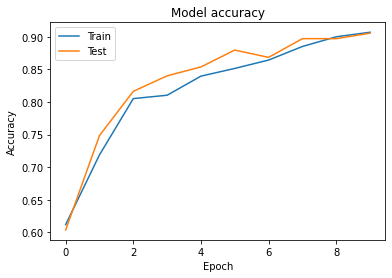

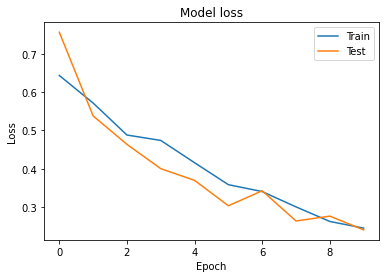

In [39]:

model_rnn3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model_rnn3.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=100, 
                    validation_data=(X_test, y_test))
plot(history)